In [4]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
from keras.utils  import to_categorical
import tensorflow as tf
import pickle

In [2]:
def load_rottenvsfresh():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('train')):
        if quality[0] in cata:
            path_main=os.path.join('train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        else:
            path_main=os.path.join('train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
    print('Shuffling data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y

In [5]:
X,Y=load_rottenvsfresh()

100%|███████████████████████████████████████████████████████████████████████| 10901/10901 [00:00<00:00, 1568834.34it/s]

Shuffling data.....


In [6]:
Y=np.array(Y)
X=np.array(X)
y_ser=pd.Series(Y)
y_ser.value_counts()

1    6161
0    4740
dtype: int64

In [7]:
def load_rottenvsfresh_valset():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('test')):
        if quality[0] in cata:
            path_main=os.path.join('test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        else:
            path_main=os.path.join('test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y 

In [8]:
X_val,Y_val=load_rottenvsfresh_valset()

100%|██████████████████████████████████████████████████████████████████████████| 2698/2698 [00:00<00:00, 891884.63it/s]

Shuffling your data.....


In [9]:
Y_val=np.array(Y_val)
X_val=np.array(X_val)
y_ser=pd.Series(Y_val)
y_ser.value_counts()

1    1534
0    1164
dtype: int64

In [9]:
import keras 
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D
from keras.models import Sequential

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

In [11]:
X=X/255.0
X_val=X_val/255.0

In [16]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='max',
    min_lr=0.00002, cooldown=2)
check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='new.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

model.compile(loss=keras.losses.binary_crossentropy, optimizer = keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

In [17]:
#history=model.fit(X,Y,batch_size=20,epochs= 8)
history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_val),epochs= 35,
                 callbacks=[check_point])

Epoch 1/35
546/546 [==============================] - 588s 1s/step - loss: 0.3511 - accuracy: 0.8727 - val_loss: 0.7561 - val_accuracy: 0.8188

Epoch 00001: val_loss improved from inf to 0.75606, saving model to new.h5
Epoch 2/35
546/546 [==============================] - 534s 978ms/step - loss: 0.1813 - accuracy: 0.9372 - val_loss: 0.1584 - val_accuracy: 0.9355

Epoch 00002: val_loss improved from 0.75606 to 0.15841, saving model to new.h5
Epoch 3/35
546/546 [==============================] - 534s 979ms/step - loss: 0.1668 - accuracy: 0.9429 - val_loss: 0.4709 - val_accuracy: 0.8506

Epoch 00003: val_loss did not improve from 0.15841
Epoch 4/35
546/546 [==============================] - 535s 979ms/step - loss: 0.1230 - accuracy: 0.9523 - val_loss: 0.1359 - val_accuracy: 0.9592

Epoch 00004: val_loss improved from 0.15841 to 0.13588, saving model to new.h5
Epoch 5/35
546/546 [==============================] - 539s 988ms/step - loss: 0.0961 - accuracy: 0.9659 - val_loss: 0.1810 - val_ac

In [19]:
model.evaluate(X_val,Y_val)

85/85 [==============================] - 17s 197ms/step - loss: 0.0113 - accuracy: 0.9948


[0.011328138411045074, 0.9948109984397888]

In [18]:
model.save('rottenvsfresh1.h5')

In [46]:
#fresh=0
#rotten=1

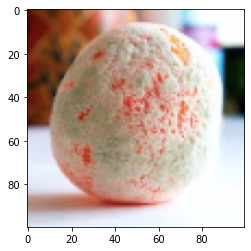

In [27]:
plt.imshow(X_val[0])

In [42]:
model.predict_classes(X_val[0].reshape(1,100,100,3))

array([[1]])

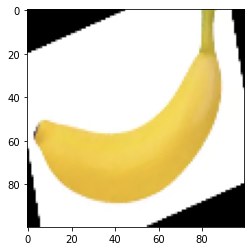

In [30]:
plt.imshow(X_val[2])

In [41]:
model.predict_classes(X_val[2].reshape(1,100,100,3))

array([[0]])

In [45]:
model.predict_classes(X_val[:30])

array([[1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1]])